## Author: Yiding Li


Import torch. For reproducibility, set its seed manually.

The model should converge quickly even if the seed is not set, but setting the seed guarantees it. Note: Torch uses its own random seed. Set it by calling `torch.manual_seed(...)`.

In [1]:
import torch
torch.manual_seed(1)

# Neural Network Demo

This demo shows how to use neural networks (PyTorch) to construct a shallow neural network. This network takes one value and returns one value, but may use a customisable number of hidden units.

This demo will primarily use these packages:

* `numpy` has some useful functions and data structures. 
* `torch.nn` supplies building blocks for neural networks, in particular `torch.nn.Module`.
* `torch.optim` contains optimisers. These are vital to fitting models to actual data.

In [2]:
import torch.nn as nn

## Explore the Data

This demo uses the Iris data set. It's a simple data set with 4 numeric features and 1 categorical feature.

The data set is sourced from the [UCI Machine Learning Repository](https://doi.org/10.24432/C56C76) under the [Creative Commons Attribution 4.0 International](
https://creativecommons.org/licenses/by/4.0/legalcode) license.

To begin, import Pandas to load the data. Print its first few entries to check if the import has been successful. Note that the original 5th column is named "class" $\textrm{\textendash}$ it is good practice to rename it, so that it does not conflict with the Python keyword `class`.

Calling `iris_data.info()` returns an object that describes the data set. Jupyter notebook is able to visualise that object.

In [3]:
import pandas
# Define column names
column_names = ['sepal_length_cm',
                'sepal_width_cm',
                'petal_length_cm',
                'petal_width_cm',
                'iris_class']
# Import data with specified column names.
iris_data = pandas.read_csv("./iris.data", names=column_names)
print(iris_data[:9],"\n")

iris_data.info()

   sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm  \
0              5.1             3.5              1.4             0.2   
1              4.9             3.0              1.4             0.2   
2              4.7             3.2              1.3             0.2   
3              4.6             3.1              1.5             0.2   
4              5.0             3.6              1.4             0.2   
5              5.4             3.9              1.7             0.4   
6              4.6             3.4              1.4             0.3   
7              5.0             3.4              1.5             0.2   
8              4.4             2.9              1.4             0.2   

    iris_class  
0  Iris-setosa  
1  Iris-setosa  
2  Iris-setosa  
3  Iris-setosa  
4  Iris-setosa  
5  Iris-setosa  
6  Iris-setosa  
7  Iris-setosa  
8  Iris-setosa   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column  

## Construct Model

Construct a neural network for this task. Call it `ShallowNet`. The network receives 4 values (corresponding the 4 numeric features), uses 2 hidden layers of width 9, and outputs 3 values. Each $i^\textrm{th}$ item in the output is the confidence, according to the model, that the observation belongs to the $i^\textrm{th} class$.

Do not forget to define the `device`! This is where actual computation will take place. Large models often demand special platforms such as GPUs (graphics processing units). Use CPU for now, since most people have them.

Optionally, you can initialise the parameters (the `nn.init` module has functions for ths purpose). It is not done here, since the default initialisation scheme already wors quite well.

In [4]:
# A CPU should be available on your machine.
device = torch.device('cpu')

In [5]:
class ShallowNet(nn.Module):
  def __init__(self):
    # Don't forget to call __init__ in the superclass!
    super().__init__()

    INPUT_DIM: int = 4
    HIDDEN_UNIT_WIDTH = 9
    OUTPUT_CLASSES: int = 3
    ACTIVATION_FUNCTION = nn.ReLU
    # Define the input layer, hidden layers and the output layer.
    # The output layer takes values emitted by the hidden layer,
    #   then returns a weighted sum (for `OUTPUT_DIM=1`).
    self.input = nn.Linear(INPUT_DIM, HIDDEN_UNIT_WIDTH)
    self.H1 = nn.Linear(HIDDEN_UNIT_WIDTH, HIDDEN_UNIT_WIDTH)
    self.H2 = nn.Linear(HIDDEN_UNIT_WIDTH, HIDDEN_UNIT_WIDTH)
    self.output = nn.Linear(HIDDEN_UNIT_WIDTH, OUTPUT_CLASSES)

    # For simplicity, group these layers in a container.
    # `nn.Sequential` composes these layers sequentially.
    self.layers = nn.Sequential(
      self.input,
      ACTIVATION_FUNCTION(),
      self.H1,
      ACTIVATION_FUNCTION(),
      self.H2,
      ACTIVATION_FUNCTION(),
      self.output
    )

  def forward(self, input):
    # Give the input to the layers.
    return self.layers(input)

shallow_net = ShallowNet().to(device)

## Define Optimiser

Use the gradient descent optimiser. Here, `lr` stands for the _learning rate_, a hyperparameter.

Please see https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
for more information, as well as other parameters.

In [6]:
import torch.optim

optimizer = torch.optim.SGD(shallow_net.parameters(), lr=0.01)

loss_function = nn.CrossEntropyLoss()

## Process Data

The data set does not contain malformed or missing values. Still, to use it to train the model, its X values (predictors) and Y values (responses) must be processed to something that the model can recognise.

Extracting **predictors** is simple. Just take the first 4 columns of the `iris_data`.

**Observed responses** are a bit harder to manage. To begin, it is helpful to map class names to ordinal values. From this point on, the text labels `Iris-setosa`, `Iris-versicolor`, and `Iris-virginica` correspond to indexes 0, 1, and 2 respectively.

To preprocess the responses, look at what the model emits. Remember that the model outputs a 3-vector, where the $i\mathrm{th}$ item corresponds to its "confidence" that the observation falls into class $i$. We are in luck! Because the observations have _been observed_ to happen, each observation _most certainly_ falls into its observed class. Therefore, transform the column `iris_classes` according to the following rule:

* `Iris-setosa`, class 0, to `[1, 0, 0]`
* `Iris-versicolor`, class 1, to `[0, 1, 0]`
* `Iris-virginica`, class 2, to `[0, 0, 1]`

In [7]:
X = torch.tensor(iris_data.iloc[:,:4].values, dtype=torch.float32)
Y = torch.tensor(iris_data['iris_class'].map({
    "Iris-setosa": [1, 0, 0],
    "Iris-versicolor": [0, 1, 0],
    "Iris-virginica": [0, 0, 1]}), dtype=torch.float32)

## Let the Learning Begin!

Run the optimiser. During each iteration, collect the cross-entropy error in `errors`.

In [8]:
errors = []

In [9]:
# Run the algorithm for this many iterations
EPOCH = 1000

for _ in range(EPOCH):
    # Apply the model to the test data.
    # Note that this example does not use a holdout set.
    model_outputs = shallow_net(X)
    # Compute the accumulated loss.
    loss = loss_function(model_outputs, Y)
    # Record the loss for plotting. This step can be omitted.
    errors.append(loss.item())
    # "Forget" the old gradient from the last iteration.
    optimizer.zero_grad()
    # Back-propagation
    loss.backward()
    # Perform gradient descent
    optimizer.step()

Plot the convergence curve: it looks quite smooth, thanks to the learning rate being low.

As an experiment, increase the learning rate (to between 0.1 and 10). You should observe spikes in the curve.

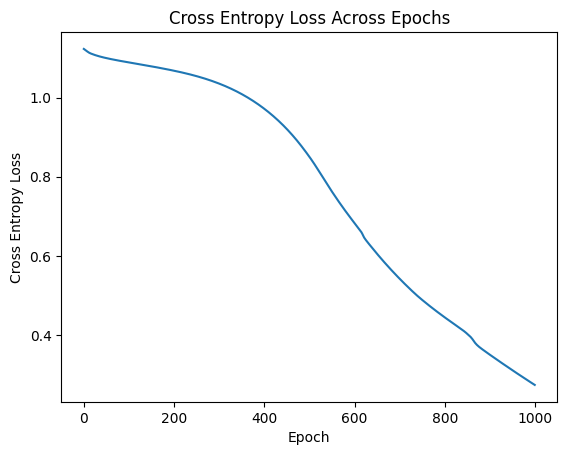

In [10]:
import matplotlib.pyplot as plt
plt.title("Cross Entropy Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.plot(range(len(errors)), errors)
plt.show()

## Visualise

The easiest way to visualise a network is by printing it directly.

In [11]:
print(shallow_net)

ShallowNet(
  (input): Linear(in_features=4, out_features=9, bias=True)
  (H1): Linear(in_features=9, out_features=9, bias=True)
  (H2): Linear(in_features=9, out_features=9, bias=True)
  (output): Linear(in_features=9, out_features=3, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=9, bias=True)
    (1): ReLU()
    (2): Linear(in_features=9, out_features=9, bias=True)
    (3): ReLU()
    (4): Linear(in_features=9, out_features=9, bias=True)
    (5): ReLU()
    (6): Linear(in_features=9, out_features=3, bias=True)
  )
)


There are many ways to visualise neural networks, such as `torchview` and `torchviz`. This example uses `torchviz`.

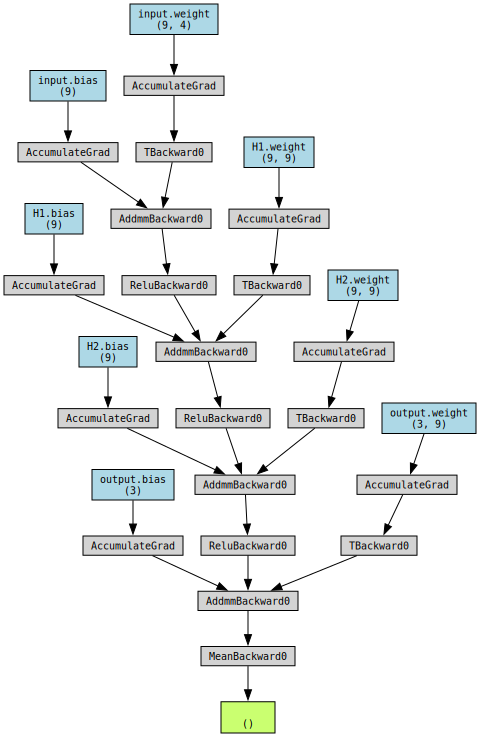

In [12]:
from torchviz import make_dot

make_dot(shallow_net(X).mean(), params=dict(shallow_net.named_parameters()))
